# Comparing quantum kernel methods

We will compare 3 feature maps in their preformence solving 3 different problems(datasets). For these feature maps we will use the corresponding kernels, commonly paired with them in papers.

The feature maps:

1.   Amplitude-Encoding
2.   Variational Kernel
3.  Squeezing

The problems:


1.   Iris
2.   Digits 0s and 1s
3.   Moons


Importing libraries

In [2]:
!pip install qiskit_machine_learning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 5.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 237.5/237.5 kB 16.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 74.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 62.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 MB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.5/108.5 kB 7.3 MB/s eta 0:00:00
  Created wheel for fastdtw: filename=fastdtw-0.3.4-cp310-cp310-linux_x86_64.whl size=512556 sha256=18321f823ad1cd987032300ed3aecfc2be4a3adaedcf501be827bc6c55901560
  Stored in directory: /root/.cache/pip/wheels/73/c8/f7/c25448dab74c3acf4848bc25d513c736bb93910277e1528ef4
Successfully built fastdtw


In [22]:

#setting seed

from sklearn.cluster import SpectralClustering
from sklearn.metrics import normalized_mutual_info_score
'''
from qiskit.circuit.library import ZZFeatureMap
from qiskit_machine_learning.kernels import FidelityQuantumKernel
from qiskit_machine_learning.datasets import ad_hoc_data'''
import matplotlib.pyplot as plt
import numpy as np

from sklearn import datasets
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
#from sklearn.metrics import accuracy_score
#from qiskit_aer import Aer
#from qiskit.utils import QuantumInstance
#from qiskit_machine_learning.kernels import QuantumKernel

from qiskit import QuantumCircuit, transpile
from qiskit.primitives import Estimator
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
from sklearn.svm import SVC
import numpy as np

from qiskit.quantum_info import Statevector
from qiskit.circuit.library import ZZFeatureMap
from qiskit.circuit.library import TwoLocal



Setting up the feature maps

In [23]:
# Amplitude-Encoding Feature Map

def amplitude_encoding(data):
    n_qubits = int(np.ceil(np.log2(len(data))))
    circuit = QuantumCircuit(n_qubits)
    padded_data = np.zeros(2**n_qubits)
    padded_data[:len(data)] = data
    norm = np.linalg.norm(padded_data)
    normalized_data = padded_data / norm
    circuit.initialize(normalized_data, range(n_qubits))
    return circuit


# Squeezing Feature Map
def squeezing_feature_map(data):
    n_qubits = len(data)
    circuit = QuantumCircuit(n_qubits)
    for i, x in enumerate(data):
        circuit.ry(np.arcsin(np.tanh(x)), i)  # Approximate squeezing
        circuit.rz(x, i)  # Phase encoding
    return circuit

def zz_feature_map(data):
    n_qubits = len(data)
    feature_map = ZZFeatureMap(feature_dimension=n_qubits, reps=2)
    parameterized_circuit = feature_map.assign_parameters(data)
    return parameterized_circuit


Setting up the kernel

In [24]:
# Kernel computation function using Statevector for fidelity calculation
def compute_kernel(X1, X2, feature_map):
    kernel_matrix = np.zeros((len(X1), len(X2)))

    for i, x1 in enumerate(X1):
        for j, x2 in enumerate(X2):
            # Create feature map circuits
            qc1 = feature_map(x1)
            qc2 = feature_map(x2)

            # Compute statevectors
            state1 = Statevector.from_instruction(qc1)
            state2 = Statevector.from_instruction(qc2)

            # Compute fidelity
            fidelity = np.abs(state1.inner(state2)) ** 2
            kernel_matrix[i, j] = fidelity

    return kernel_matrix

#Iris

In [25]:
# Load Iris dataset and normalize

# Load Iris dataset for Amplitude-Encoding Feature Map
iris = load_iris()
X, y = iris.data, iris.target
y = (y < 2).astype(int)  # Binary classification
X = StandardScaler().fit_transform(X)  # Normalize data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


# Train and test kernel SVM
# Amplitude
train_kernel_amplitude = compute_kernel(X_train, X_train, amplitude_encoding)
test_kernel_amplitude = compute_kernel(X_test, X_train, amplitude_encoding)
# Squeezing
train_kernel_squeezing = compute_kernel(X_train, X_train, squeezing_feature_map)
test_kernel_squeezing = compute_kernel(X_test, X_train, squeezing_feature_map)
# Variational
train_kernel_variational = compute_kernel(X_train, X_train, zz_feature_map)
test_kernel_variational = compute_kernel(X_test, X_train, zz_feature_map)

svm = SVC(kernel='precomputed')
svm.fit(train_kernel_amplitude, y_train)
y_pred_amplitude = svm.predict(test_kernel_amplitude)

svm = SVC(kernel='precomputed')
svm.fit(train_kernel_squeezing, y_train)
y_pred_squeezing = svm.predict(test_kernel_squeezing)

svm = SVC(kernel='precomputed')
svm.fit(train_kernel_variational, y_train)
y_pred_variational = svm.predict(test_kernel_variational)

# Accuracy
accuracy_amplitude = np.mean(y_pred_amplitude == y_test)
accuracy_squeezing = np.mean(y_pred_squeezing == y_test)
accuracy_variational = np.mean(y_pred_variational == y_test)

print(f"Amplitude-Encoding Kernel Test Accuracy: {accuracy_amplitude * 100:.2f}%")
print(f"Squeezing-Based Kernel Test Accuracy: {accuracy_squeezing * 100:.2f}%")
print(f"Variational Kernel Test Accuracy: {accuracy_variational * 100:.2f}%")



Amplitude-Encoding Kernel Test Accuracy: 75.56%
Squeezing-Based Kernel Test Accuracy: 97.78%
Variational Kernel Test Accuracy: 73.33%


Amplitude-Encoding Kernel Test Accuracy: 75.56%
Squeezing-Based Kernel Test Accuracy: 97.78%
Variational Kernel Test Accuracy: 73.33%

# Digits

In [26]:
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from qiskit.circuit.library import ZZFeatureMap
from sklearn.preprocessing import StandardScaler
digits = load_digits()
'''
# Load and preprocess the digits dataset
digits = load_digits()
mask = np.isin(digits.target, [0, 1])
X = digits.data[mask:550]  # Features
y = (digits.target[mask:550] < 5).astype(int)  # Binary classification: Digits 0-4 vs 5-9
'''
# Filter to include only the samples with target 0 or 1
mask = np.isin(digits.target, [0, 1])
X_filtered = digits.data[mask]
y_filtered = digits.target[mask]

# Define the desired number of samples
n_samples = 360  # Set your desired number of samples

# Randomly sample n_samples from the filtered dataset
indices = np.random.choice(len(X_filtered), n_samples, replace=False)
X = X_filtered[indices]
y = y_filtered[indices]



# Normalize and split the dataset
scaler = StandardScaler()
X = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X[:, :8], y, test_size=0.3, random_state=42)  # Use first 8 features

# Train and test kernel SVM
# Amplitude
train_kernel_amplitude = compute_kernel(X_train, X_train, amplitude_encoding)
test_kernel_amplitude = compute_kernel(X_test, X_train, amplitude_encoding)
# Squeezing
train_kernel_squeezing = compute_kernel(X_train, X_train, squeezing_feature_map)
test_kernel_squeezing = compute_kernel(X_test, X_train, squeezing_feature_map)
# Variational
train_kernel_variational = compute_kernel(X_train, X_train, zz_feature_map)
test_kernel_variational = compute_kernel(X_test, X_train, zz_feature_map)

svm = SVC(kernel='precomputed')
svm.fit(train_kernel_amplitude, y_train)
y_pred_amplitude = svm.predict(test_kernel_amplitude)

svm = SVC(kernel='precomputed')
svm.fit(train_kernel_squeezing, y_train)
y_pred_squeezing = svm.predict(test_kernel_squeezing)

svm = SVC(kernel='precomputed')
svm.fit(train_kernel_variational, y_train)
y_pred_variational = svm.predict(test_kernel_variational)

# Accuracy
accuracy_amplitude = np.mean(y_pred_amplitude == y_test)
accuracy_squeezing = np.mean(y_pred_squeezing == y_test)
accuracy_variational = np.mean(y_pred_variational == y_test)

print(f"Amplitude-Encoding Kernel Test Accuracy: {accuracy_amplitude * 100:.2f}%")
print(f"Squeezing-Based Kernel Test Accuracy: {accuracy_squeezing * 100:.2f}%")
print(f"Variational Kernel Test Accuracy: {accuracy_variational * 100:.2f}%")


Amplitude-Encoding Kernel Test Accuracy: 62.96%
Squeezing-Based Kernel Test Accuracy: 75.00%
Variational Kernel Test Accuracy: 61.11%


Amplitude-Encoding Kernel Test Accuracy: 62.96% Squeezing-Based Kernel Test Accuracy: 75.00% Variational Kernel Test Accuracy: 61.11%

<Figure size 640x480 with 0 Axes>

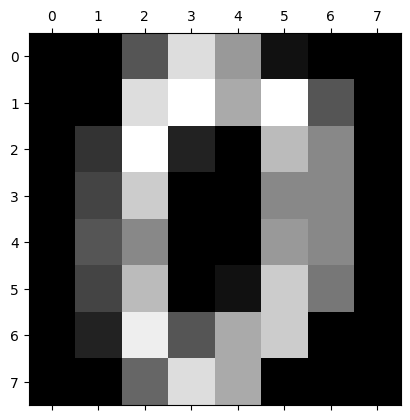

In [27]:
plt.gray()
plt.matshow(digits.images[0])
plt.show()

# Moons

In [28]:
from sklearn.datasets import make_moons

# Generate Moons dataset
X, y = make_moons(n_samples=150, noise=0.1, random_state=42)

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train and test kernel SVM
# Amplitude
train_kernel_amplitude = compute_kernel(X_train, X_train, amplitude_encoding)
test_kernel_amplitude = compute_kernel(X_test, X_train, amplitude_encoding)
# Squeezing
train_kernel_squeezing = compute_kernel(X_train, X_train, squeezing_feature_map)
test_kernel_squeezing = compute_kernel(X_test, X_train, squeezing_feature_map)
# Variational
train_kernel_variational = compute_kernel(X_train, X_train, zz_feature_map)
test_kernel_variational = compute_kernel(X_test, X_train, zz_feature_map)

svm = SVC(kernel='precomputed')
svm.fit(train_kernel_amplitude, y_train)
y_pred_amplitude = svm.predict(test_kernel_amplitude)

svm = SVC(kernel='precomputed')
svm.fit(train_kernel_squeezing, y_train)
y_pred_squeezing = svm.predict(test_kernel_squeezing)

svm = SVC(kernel='precomputed')
svm.fit(train_kernel_variational, y_train)
y_pred_variational = svm.predict(test_kernel_variational)

# Accuracy
accuracy_amplitude = np.mean(y_pred_amplitude == y_test)
accuracy_squeezing = np.mean(y_pred_squeezing == y_test)
accuracy_variational = np.mean(y_pred_variational == y_test)

print(f"Amplitude-Encoding Kernel Test Accuracy: {accuracy_amplitude * 100:.2f}%")
print(f"Squeezing-Based Kernel Test Accuracy: {accuracy_squeezing * 100:.2f}%")
print(f"Variational Kernel Test Accuracy: {accuracy_variational * 100:.2f}%")



Amplitude-Encoding Kernel Test Accuracy: 71.11%
Squeezing-Based Kernel Test Accuracy: 82.22%
Variational Kernel Test Accuracy: 66.67%


Amplitude-Encoding Kernel Test Accuracy: 71.11% Squeezing-Based Kernel Test Accuracy: 82.22% Variational Kernel Test Accuracy: 66.67%

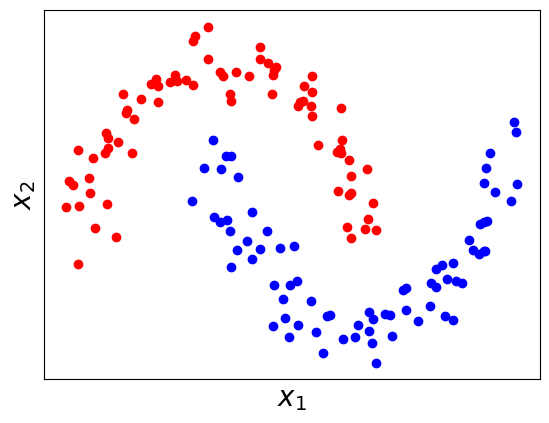

In [29]:

# 2- Visualizing the dataset.
from matplotlib import pyplot as plt

# When the label y is 0, the class is represented with a blue square.
# When the label y is 1, the class is represented with a green triangle.
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bo")
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "ro")

# X contains two features, x1 and x2
plt.xlabel(r"$x_1$", fontsize=20)
plt.ylabel(r"$x_2$", fontsize=20)

# Simplifying the plot by removing the axis scales.
plt.xticks([])
plt.yticks([])

# Displaying the plot.
plt.show()